<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems


# Distributed computing in Julia


## Contents

In this notebook, we will learn the basics of distributed computing in Julia. In particular, we will focus on the [Distributed](https://docs.julialang.org/en/v1/manual/distributed-computing/) module available in the Julia standard library. The main topics we are going to cover are:

- How to create Julia processes
- How to execute code remotely
- How to send and receive data

With this knowledge you will be able to implement simple and complex parallel algorithms in Julia.

<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the next cell before starting this notebook! 
</div>

In [ ]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
q_1_check(answer) = answer_checker(answer,"a")
q_2_check(answer) = answer_checker(answer,"b")
function why_q1()
    msg = """
    We send the matrix (16 entries) and then we receive back the result (1 extra integer). Thus, the total number of transferred integers in 17.
    """
    display(msg)
end
function why_q2()
    msg = """
    Even though we only use a single entry of the matrix in the remote worker, the entire matrix is captured and sent to the worker. Thus, we will transfer 17 integers like in Question 1.
    """
    display(msg)
end
function why_q3()
    msg = """
    The value of x will still be zero since the worker receives a copy of the matrix and it modifies this copy, not the original one.
    """
    display(msg)
end
function why_q4()
    msg = """
    In this case, the code a[2]=2 is executed in the main process. Since the matrix is already in the main process, it is not needed to create and send a copy of it. Thus, the code modifies the original matrix and the value of x will be 2.
    """
    display(msg)
end
println("🥳 Well done! ")

## How to create Julia processes

First of all, we need several processes in order to run parallel algorithms *in parallel*. In this section, we discuss different ways to create new processes in Julia.

### Adding processes locally

 The simplest way of creating processes for parallel computing is to add them locally in the current Julia session. This is done by using the following commands.


In [ ]:
using Distributed

In [ ]:
addprocs(3)

Last cell created 3 new Julia processes. By default, they run locally in the same computer as the current Julia session, using multiple cores if possible. However, it is also possible to start the new processes in other machines as long as they are interconnected (more details on this later).


<div class="alert alert-block alert-info">
<b>Tip:</b> We can also start new processes when launching Julia from the command line by suing the `-p` command-line argument. E.g., `$ julia -p 3 ` would launch Julia with 3 extra processes.
</div>


### Each process runs a separated Julia instance

When adding the new processes, you can imagine that 3 new Julia REPLs have started under the hood (see figure below). The main point of the Distributed module is to provide a way of coordinating all these Julia processes to run code in parallel. It is important to note that each process runs in a separated Julia instance. This means that each process has its own memory space and therefore they do not share memory. This results in distributed-memory parallelism, and allows one to run processes in different machines.
 
 <div>
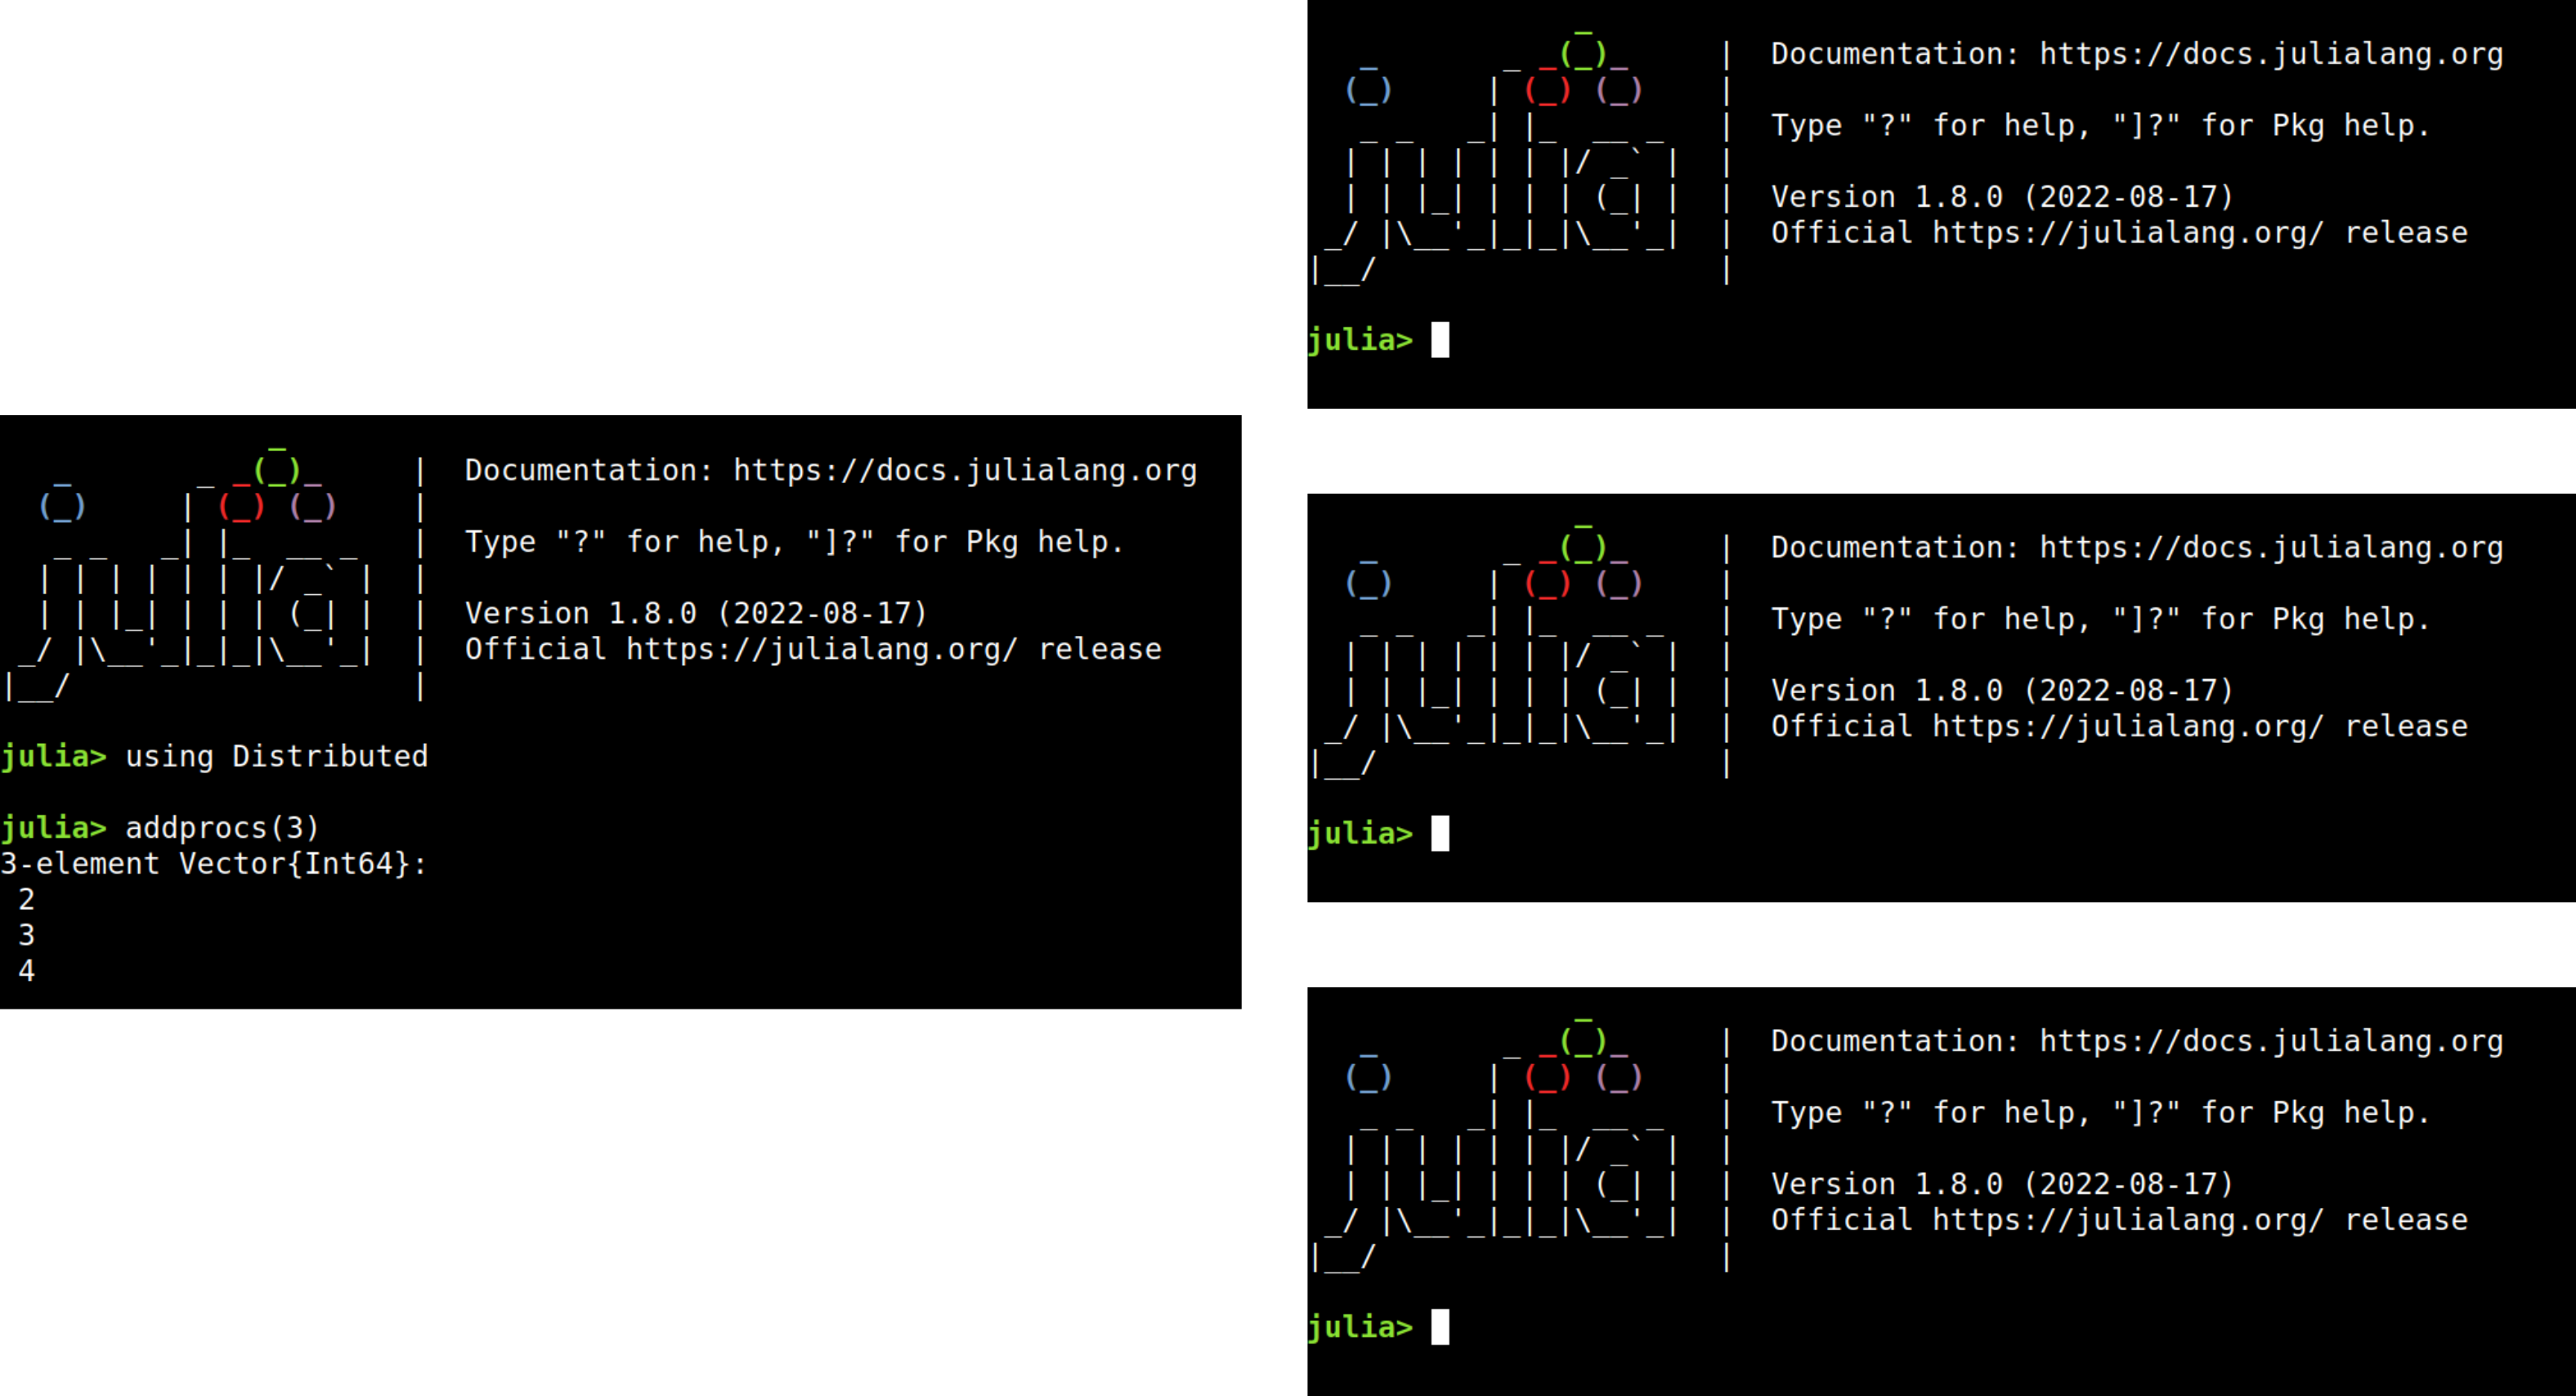
</div>
 
 

### Basic info about processes

The following functions provide basic information about the underlying processes. If more than one process is available, the first process is called the *main* or *master* and the other the *workers*. If only a single process is available, it is the master and the first worker simultaneously.

In [ ]:
procs()

In [ ]:
workers()

In [ ]:
nprocs()

In [ ]:
nworkers()

In [ ]:
myid()

In [ ]:
@everywhere println(myid())

In previous cell, we have used the macro `@everywhere` that evaluates the given code on all processes. As a result, each process will print its own process id.

### Creating workers in other machines

For large parallel computations, one typically needs to use different computers in parallel. Function `addprocs` also provides a low-level method to start workers in other machines. Next code example would create 3 workers in `server1` and 4 new workers in server `server2` (see figure below). Under the hood, Julia connects via ssh to the other machines and starts the new processes there. In order this to work, the local computer and the remote servers need to be properly configured (see the Julia manual for details). 




```julia
using Distributed
machines = [("user@server1",3),("user@server2",4)]
addprocs(machines)
```






 <div>
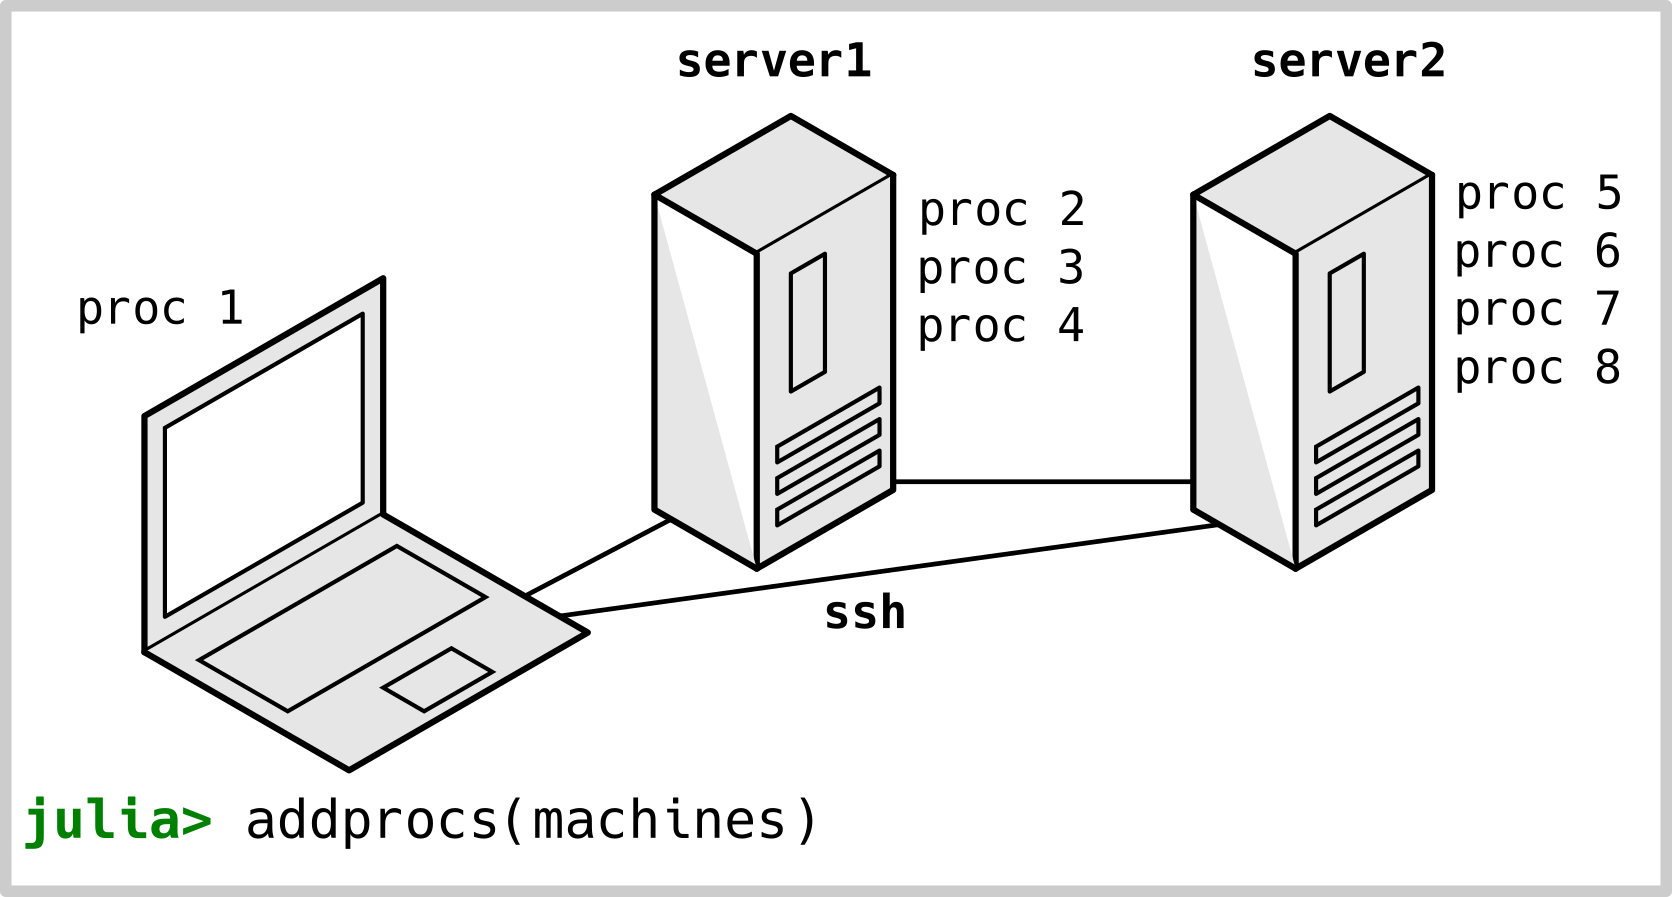
</div>



### Adding workers with ClusterManagers.jl

Previous way of starting workers in other machines is very low-level. Happily, there is a Julia package called [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl) that helps to create workers remotely in number of usual scenarios. For instance, when running the following code from the login node in a computer cluster, it will submit a job to the cluster queue allocating 128 threads. A worker will be generated for each one of these threads. If the compute node have 64 cores, 2 compute nodes will be used to create to contain the 128 workers (see below).


```julia
using Distributed
using ClusterManagers
addprocs(SlurmManager(128), partition="debug", t="00:5:00")
```



 <div>
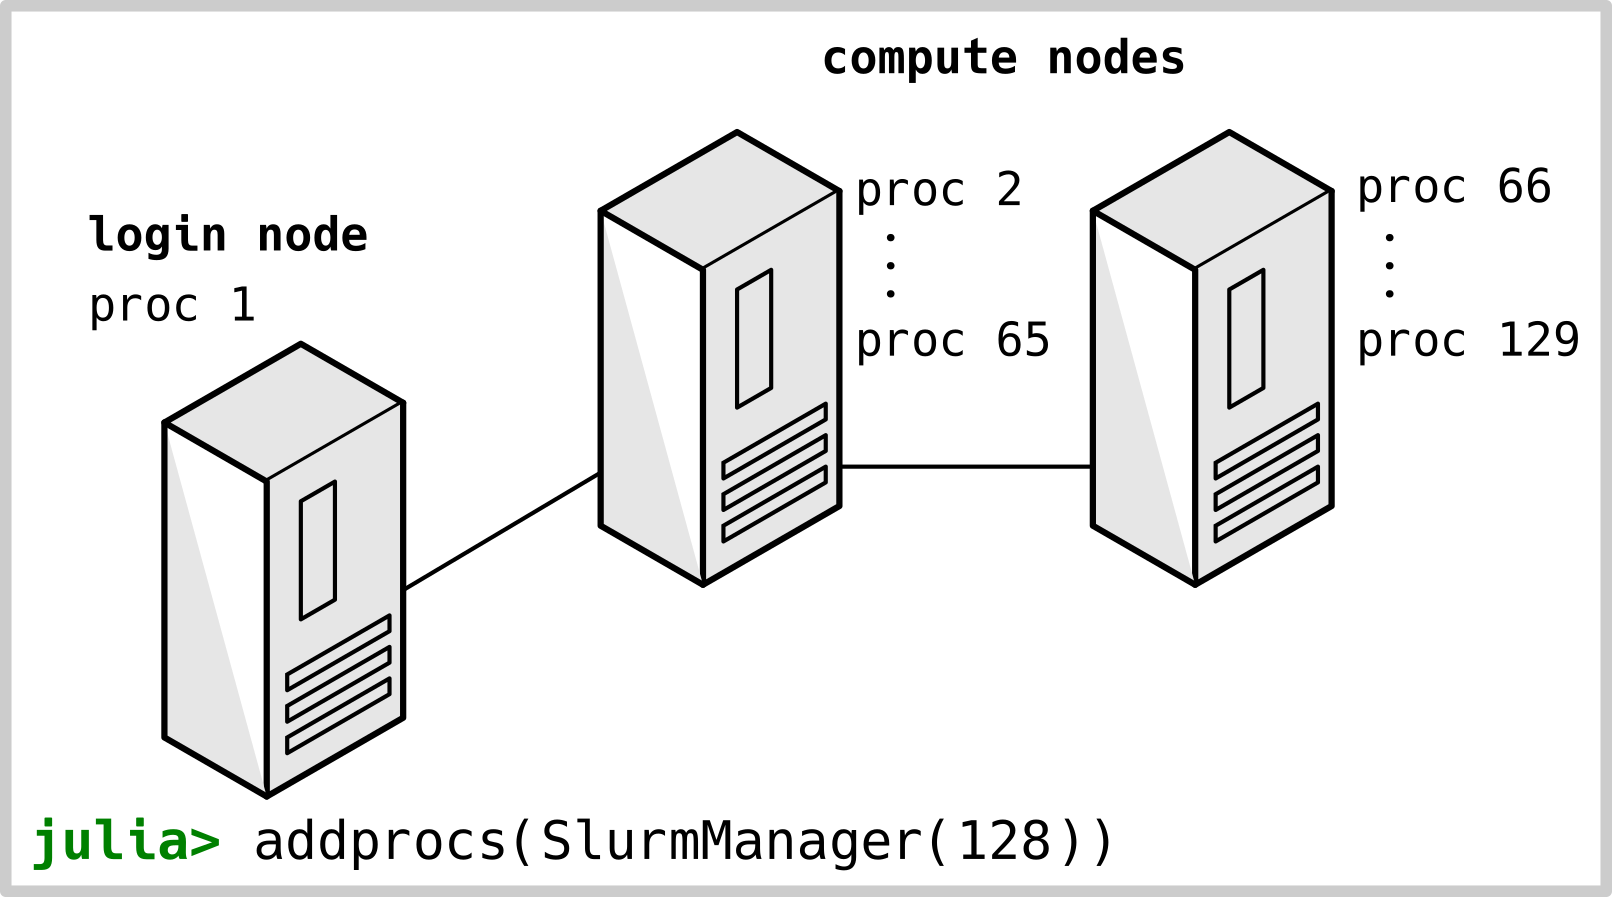
</div>

## Executing code remotely

We have added new processes to our Julia session. Let's start using them!

### Function `remotecall`

The most basic thing we can do with a remote processor is to execute a given function on it. This is done by using function `remotecall`. To make clear how local and remote executions compare, let's call a function locally and then remotely. Next cell uses function `ones` to create a matrix locally.


In [ ]:
a = ones(2,3)

The next cell does the same operation, but remotely on process 2. Note that `remotecall` takes the function we want to execute remotely, the process id where we want to execute it and, finally, the function arguments.

In [ ]:
proc = 2
ftr = remotecall(ones,proc,2,3)

Note that `remotecall` does not return the result of the underlying function, but a `Future`. This object represents a reference to a task running on the remote process. To move a copy of the result to the current process we can use `fetch`.

In [ ]:
fetch(ftr)

### `remotecall` is asynchronous

It is important to note that `remotecall` does not wait for the remote process to finish. It turns immediately. This can be checked be calling remotely the following function that sleeps for 10 secods and then generates a matrix.

In [ ]:
fun = (m,n) -> (sleep(10); ones(m,n))

When running next cell, it will return immediately, event though the remote process will sleep for 10 seconds. We can even run code in parallel. To try this execute the second next cell while the remote call is running in the worker.

In [ ]:
proc = 2
ftr = remotecall(fun,proc,2,3)

In [ ]:
1+1

However, when fetching the result, the current process blocks waiting until the result is available in the remote process and arrives to its destination.

In [ ]:
fetch(ftr)

### Useful macro: `@spawnat`

You have provably realized that in order to use `remotecall` we have written auxiliary anonymous functions. They are needed to wrap the code we want to execute remotely. Writing these functions can be tedious. Happily, the macro `@spawnat` generates an auxiliary function from the given block of code and calls `remotecall` for us. For instance, the two following cells are equivalent.

In [ ]:
@spawnat proc ones(2,3)

In [ ]:
fun = () -> ones(2,3)
remotecall(fun,proc)

###  `@async` vs `@spawnat`

The relation between `@async` and `@pawnat` is obvious. From the user perspective they work almost in the same way. However,  `@async` generates a task that runs asynchronously in the current process, whereas `@spawnat` executes a task in a remote process in parallel. In both cases, the result is obtained using `fetch`. 

In [ ]:
tsk = @async begin
    sleep(3)
    zeros(2)
end
fetch(tsk)

In [ ]:
ftr = @spawnat :any begin
    sleep(3)
    zeros(2)
end
fetch(ftr)

### Another usefull macro: `@fetchfrom`

Macro `@fetchfrom` is the blocking version of `@spawnat`. It blocks and returns the corresponding result instead of a `Future` object. 

In [ ]:
a = @fetchfrom proc begin
    sleep(3)
    zeros(2)
end

## Data movement

Data movement is a crucial part in distributed-memory computations and it is usually one of its main computational
bottlenecks. Being aware of the data we are moving when using functions such as `remotecall` is important to write efficient distributed algorithms in Julia. Julia also provides a special type of channel, called remote channel, to send and receive data between processes.

### Data movement in `remotecall` / `fetch`

When usig `remotecall` we send to the remote process a function and its arguments. In this example, we send function name `+` and matrices `a` and `b` to proc 4. When fetching the result we receive a copy of the matrix from proc 4.

In [ ]:
proc = 4
a = rand(10,10)
b = rand(10,10)
ftr = remotecall(+,proc,a,b)
fetch(ftr);

### Implicit data movement

Be aware that data movements can be implicit. This usually happens when we execute remotely functions that capture variables. In the following example, we are also sending matrices `a` and `b` to proc 4, even though they do not appear as arguments in the remote call. These variables are captured by the anonymous function and will be sent to proc 4.

In [ ]:
proc = 4
a = rand(10,10)
b = rand(10,10)
fun = () -> a+b
ftr = remotecall(fun,proc)
fetch(ftr);

### Data movement with remote channels

Another way of moving data between processes is to use remote channels. Their usage is very similar to conventional channels for moving data between tasks, but there are some important differences. In the next cell, we create a remote channel. Process 4 puts several values and closes the channel. Like for conventional channels, calls to `put!` are blocking, but next cell is not blocking the master process since the call to `put!` runs asynchronously on process 4.

In [ ]:
fun = ()->Channel{Int}()
chnl = RemoteChannel(fun)

In [ ]:
@spawnat 4 begin
    for i in 1:5
        put!(chnl,i)
    end
    close(chnl)
end;

We can take values from the remote channel form any process using `take!`. Run next cell several times. The sixth time it should raise and error since the channel was closed.

In [ ]:
take!(chnl)

### This will not work!

```julia
chnl = Channel{Int}()
@spawnat 4 begin
    for i in 1:5
        put!(chnl,i)
    end
    close(chnl)
end
take!(chnl)
```

You really need remote channels to communicate different processes. Standard Channels would not work. For instance, the following code would block at the `take!`. Worker 4 will receive a different copy of the channel and will put values in it. The channel defined in the main process will remain empty and this will make the take! to block. 



### Remote channels can be buffered

Just like conventional channels, remote channels can be buffered. The buffer is stored in the process that owns the remote channel. By default this corresponds to process that creates the remote channel, but it can be a different one. For instance, process 3 will be the owner in the following example.

In [ ]:
buffer_size = 2
owner = 3
fun = ()->Channel{Int}(buffer_size)
chnl = RemoteChannel(fun,owner)

In [ ]:
@spawnat 4 begin
    println("start")
    for i in 1:5
        put!(chnl,i)
        println("I have put $i")
    end
    close(chnl)
    println("stop")
end;

Note that since the channel is buffered, worker 4 can start putting values into it before any call to `take!`. Run next cell several times until the channel is closed.

In [ ]:
take!(chnl)

### Remote channels are not iterable

One main difference with respect to conventional channels is that remote channels cannot be iterated. Let's repeat the example above.

In [ ]:
fun = ()->Channel{Int}()
chnl = RemoteChannel(fun)

In [ ]:
@spawnat 4 begin
    for i in 1:5
        put!(chnl,i)
    end
    close(chnl)
end;

Now, try to iterate over the channel in a for loop. It will result in an error since channels are not iterable.

In [ ]:
for j in chnl
    @show j
end

If we want to take values form a remote channel and stop automatically when the channel is closed, we can combine a while loop and a try-catch statement. This works since `take!` raises an error if the channel is closed, which will execute the `catch` block and breaks the loop.

In [ ]:
while true
    try
        j = take!(chnl)
        @show j
    catch
        break
    end
end

## Questions


<div class="alert alert-block alert-success">
<b>Question (NB3-Q1):</b>  How many integers are transferred between master and worker? Including both directions. 
</div>



```julia
a = rand(Int,4,4)
proc = 4
@fetchfrom proc sum(a^2)
```

    a) 17
    b) 32
    c) 16^2
    d) 65

In [ ]:
answer = "x" #Replace x with a, b, c, or d
q_1_check(answer)

In [ ]:
why_q1()

<div class="alert alert-block alert-success">
<b>Question (NB3-Q2):</b>  How many integers are transferred between master and worker? Including both directions. 
</div>



```julia
a = rand(Int,4,4)
proc = 4
@fetchfrom proc sum(a[2,2]^2)
```

    a) 2
    b) 17
    c) 5
    d) 32

In [ ]:
answer = "x" #Replace x with a, b, c, or d
q_2_check(answer)

In [ ]:
why_q2()


<div class="alert alert-block alert-success">
<b>Question (NB3-Q3):</b>  Which value will be the value of `x` ? 
</div>


In [ ]:
a = zeros(Int,3)
proc = 3
@sync @spawnat proc a[2] = 2
x = a[2]
x

In [ ]:
why_q3()

<div class="alert alert-block alert-success">
<b>Question (NB3-Q4):</b>  Which value will be the value of `x` ? 
</div>

Which value will be the value of `x` ?

In [ ]:
a = zeros(Int,3)
proc = myid()
@sync @spawnat proc a[2] = 2
x = a[2]
x

In [ ]:
why_q4()

## Remember: each process runs in a separated Julia instance

In particular, this means that each process can load different functions or packages. In consequence, it is important to make sure that the code we run is defined in the corresponding process.



### Functions are defined in a single process

This is a very common pitfall when running parallel code. If we define a function in a process, it is not automatically available in the other processes. This is illustrated in the next example. The remote call in the last line in next cell will fail since the function `sleep_ones` is only being defined in the local process. 

In [ ]:
function sleep_ones(m,n)
    sleep(4)
    ones(m,n)
end

In [ ]:
proc = 3
remotecall_fetch(sleep_ones,proc,3,4)

To fix this, we can define the function on all processes with the `@everywhere` macro.

In [ ]:
@everywhere function sleep_ones(m,n)
    sleep(4)
    ones(m,n)
end

In [ ]:
proc = 3
remotecall_fetch(sleep_ones,proc,3,4)

### Anonymous functions are available everywhere

If a function has a name, Julia only sends the function name to the corresponding process. Then, Julia looks for the corresponding function code in the remote process and executes it. This is why the function needs to be defined also in the remote process. However, if a function is anonymous, Julia needs to send the complete function definition to the remote process. This is why anonymous functions do not need to be defined with the macro `@everywhere` to work in a remote call.


In [ ]:
fun = (m,n) -> (sleep(4);ones(m,n))

In [ ]:
proc = 3
remotecall_fetch(fun,proc,3,4)

### Each proc uses packages independently

When using a package in a process, it is not available in the other ones. For instance, if we load the `LinearAlgebra` package in the current process and use one of its exported functions in another process, we will get an error.

In [ ]:
using LinearAlgebra

In [ ]:
@fetchfrom 3 norm([1,2,3])

To fix this, we can load the package on all processors with the `@everywhere` macro.

In [ ]:
@everywhere using LinearAlgebra

In [ ]:
@fetchfrom 3 norm([1,2,3])

### Each process has its own active package environment

This is another very common source of errors. You can check that if you activate the current directory, this will have no effect in the other processes.

In [ ]:
] activate .

We have activated the current folder. Now let's see which is the active project in another process, say process 2. You will see that process 2 is provably still using the global package environment.

In [ ]:
@everywhere using Pkg

In [ ]:
@spawnat 2 Pkg.status();

To fix this, you need to activate the current directory on all processes.

In [ ]:
@everywhere Pkg.activate(".")

In [ ]:
@spawnat 2 Pkg.status();

## Easy ways of parallelizing code

A part from the low-level parallel routines we have seen so-far, Julia also provides much more simple ways to parallelizing loops and maps.

### Useful macro: @distributed

This macro is used when we want to perform a very large for loops made of independent small iterations. To illustrate this, let's consider again the function that computes $\pi$ with Leibniz formula.

In [ ]:
function compute_π(n)
    s = 1.0
    for i in 1:n
        s += (isodd(i) ? -1 : 1) / (i*2+1)
    end
    4*s
end

Paralelizing this function might require some work with low-level functions like `remotecall`, but it is trivial using the macro `@distributed`. This macro runs the for loop using the available processes and optionally reduces the result using a given reduction function (`+` in this case).

In [ ]:
function compute_π_dist(n)
    s = 1.0
    r = @distributed (+) for  i in 1:n
        (isodd(i) ? -1 : 1) / (i*2+1)
    end
    4*(s+r)
end

Run next cell to measure the performance of the serial function for a large value of `n`. Run it at least 2 times to get rid of compilation times.

In [ ]:
@time compute_π(4_000_000_000)

Run next cell to measure the performance of the parallel function.

In [ ]:
@time compute_π_dist(4_000_000_000)

### Useful function: `pmap`

This function is used when we want to call a very expensive function a small number of evaluations and we want to distribute these evaluations over the available processes. To illustrate the usage of `pmap` consider the following example. Next cell generates sixty 30x30 matrices. The goal is to compute the singular value decomposition of all of them. This operation is known to be expensive for large matrices. Thus, this is a perfect scenario for `pmap`.

In [ ]:
a = [ rand(300,300) for i in 1:60];

First, lets measure the serial performance

In [ ]:
using LinearAlgebra

In [ ]:
@time svd.(a);

If we use `pmap` instead of broadcast, the different calls to `svd` will be distributed over the available processes.

In [ ]:
@time pmap(svd,a);

## Summary

We have seen the basics of distributed computing in Julia. The programming model is essentially an extension of tasks and channels to parallel computations on multiple machines. The low-level functions are `remotecall` and `RemoteChannel`, but there are other functions and macros like `pmap` and `@distributed` that simplify the implementation of parallel algorithms.

## Exercises

### Exercise 1

Implement this "simple" algorithm (the telephone game):

Worker 1 generates a message (an integer). Worker 1 sends the message to worker 2. Worker 2 receives the message, increments the message by 1, and sends the result to worker 3. Worker 3 receives the message, increments the message by 1, and sends the result to worker 4. Etc. The last worker sends back the message to worker 1 closing the ring. See the next figure.

<div>
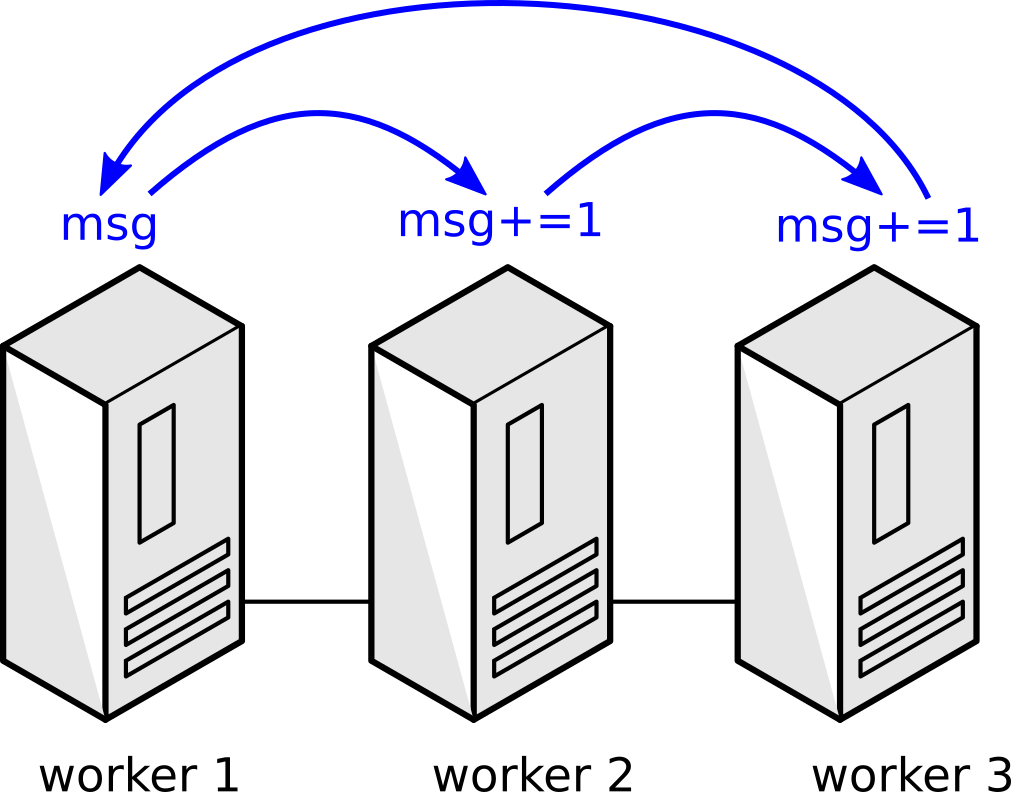
</div>
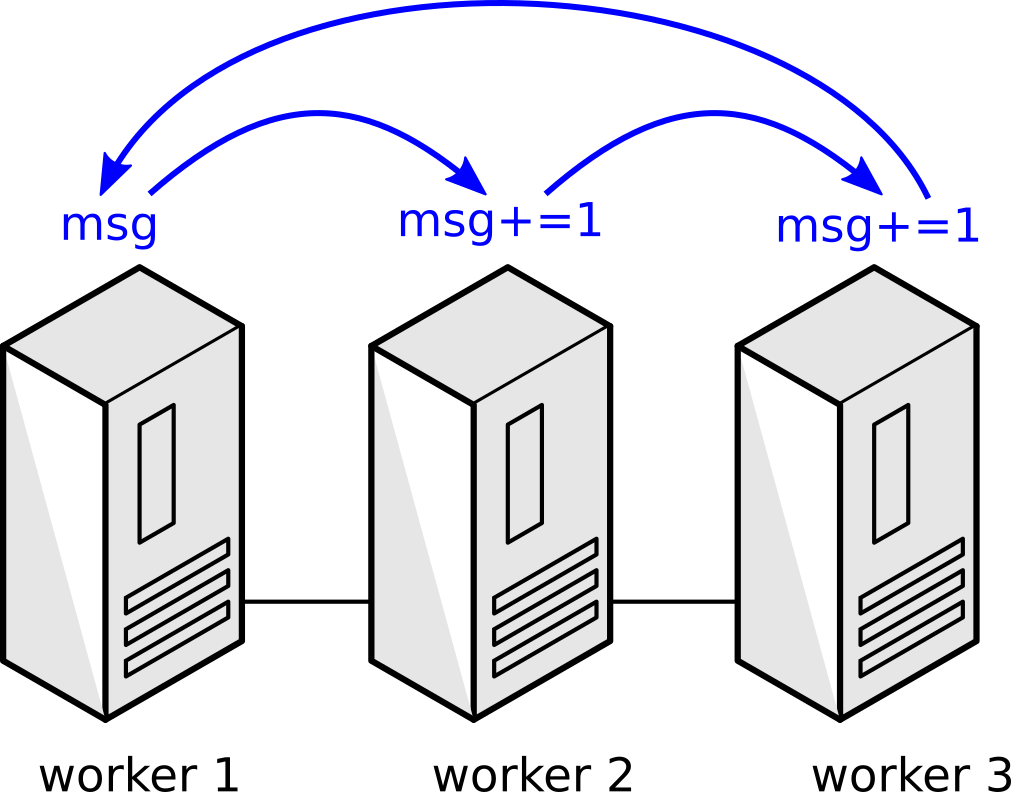

# License

This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.